<a href="https://colab.research.google.com/github/evandwh/Data-Viz-Portfolio/blob/main/Task3/ST554_Project_1_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 1 - Task 3

**Need to do:**

*   Add much more detail in explanation of the code and the results
*   Check and see if MSE needs to be averaged or simply summed.
*   If it does need to be averaged (as I expect it does), then need to update conclusion.



##Data Import

In order to get the data we will fit the models to, we need to install the correct repo below.

In [179]:
!pip install ucimlrepo

Now that the repo is installed, we need to import all of the modules needed to do our model fitting.

In [34]:
import ucimlrepo as uci
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import linear_model


Next, we will make sure that we fetch the correct data from the repo, and take a look at the data we will be working with. There are many variables that will not be used.

The main variables we will be examining are `Date`, `CO(GT)`, `C6H6(GT)`,`T`,`RH`, and `AH`.

*   `Date` - Date of the observation
*   `CO(GT)` - True hourly averaged concentration CO in mg/m^3 (reference analyzer)
*   `C6H6(GT)` - True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
*   `T` - Temperature
*   `RH`- Relative Humidity
*   `AH`- Absolute Humidity



In [180]:
air_quality = uci.fetch_ucirepo(id=360)

air_quality.data.features

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


##Data Cleaning

For the purpose of this study, we will save enter the data as a dataframe but ignore any entry that is missing values for the variables we are studying.

We were left with 7344 data entries.

In [5]:
#Turning the features attribute into a named dataframe.
air_quality_df = air_quality.data.features

# Removing rows where C6H6(GT), CO(GT), T, RH, or AH is -200 (missing)
cleaned_aq_df = air_quality_df[(air_quality_df['C6H6(GT)'] != -200)  &
                               (air_quality_df['CO(GT)'] != -200) &
                               (air_quality_df['T'] != -200) &
                               (air_quality_df['RH'] != -200) &
                               (air_quality_df['AH'] != -200) ].copy()


#Checking to see how values were still present in the data set.
cleaned_aq_df.shape

(7344, 15)

Because our `Date` variable was entered in as strings and we want to keep them in chronological order, we need to create a day column to keep track of the day number. This will allow us to keep the data in chronological order should someone want to glance at the raw data.

In [6]:
# Convert 'Date' column to datetime objects to ensure correct chronological sorting
cleaned_aq_df['Date_datetime'] = pd.to_datetime(cleaned_aq_df['Date'])

# Get unique sorted datetime objects
unique_dates = cleaned_aq_df['Date_datetime'].sort_values().unique()

# Create a mapping from each unique date to a 1-based integer day
date_to_day_map = {date: i + 1 for i, date in enumerate(unique_dates)}

# Apply the mapping to create the new 'Day' column
cleaned_aq_df['Day'] = cleaned_aq_df['Date_datetime'].map(date_to_day_map)

We want to look at the average daily readings for the different variables. We will group all of the entries by day and then average our variables of interest.

Below is a sample of the data averaged together for our variables of interest. There are *347 days* with observations that we can use for our model.

In [181]:
daily_avg_df = cleaned_aq_df.groupby('Day') \
              .mean(numeric_only=True) \
              [['C6H6(GT)','CO(GT)','T','RH','AH']]

daily_avg_df

,C6H6(GT),CO(GT),T,RH,AH
Day,,,,,
1,8.450000,1.966667,12.033333,54.900000,0.765633
2,8.269565,2.239130,9.826087,64.230435,0.777039
3,12.177273,2.804545,11.618182,50.190909,0.665164
4,11.121739,2.695652,13.121739,50.682609,0.733013
5,9.830435,2.469565,16.182609,48.317391,0.849209
...,...,...,...,...,...
343,5.220833,1.387500,17.550000,50.083333,0.951917
344,3.526087,1.108696,16.026087,35.404348,0.631135
345,2.529167,0.854167,15.483333,32.225000,0.546167


##Models

We will now look at creating a model to predict the amount of daily average C6H6(GT) based on the other variables. The graph below shows that CO(GT) and C6H6(GT) have a positive linear association. This gives us probable cause to create a model for predicting C6H6(GT) based on CO(GT).

The pairplot below shows that no other variable has a relationship with C6H6(GT) as strong as CO(GT). Therefore, CO(GT) will be

<Axes: xlabel='CO(GT)', ylabel='C6H6(GT)'>

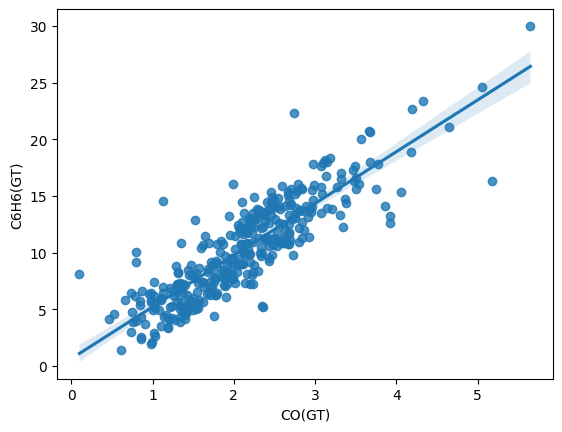

In [183]:
sns.regplot(x = daily_avg_df['CO(GT)'], y = daily_avg_df['C6H6(GT)'])

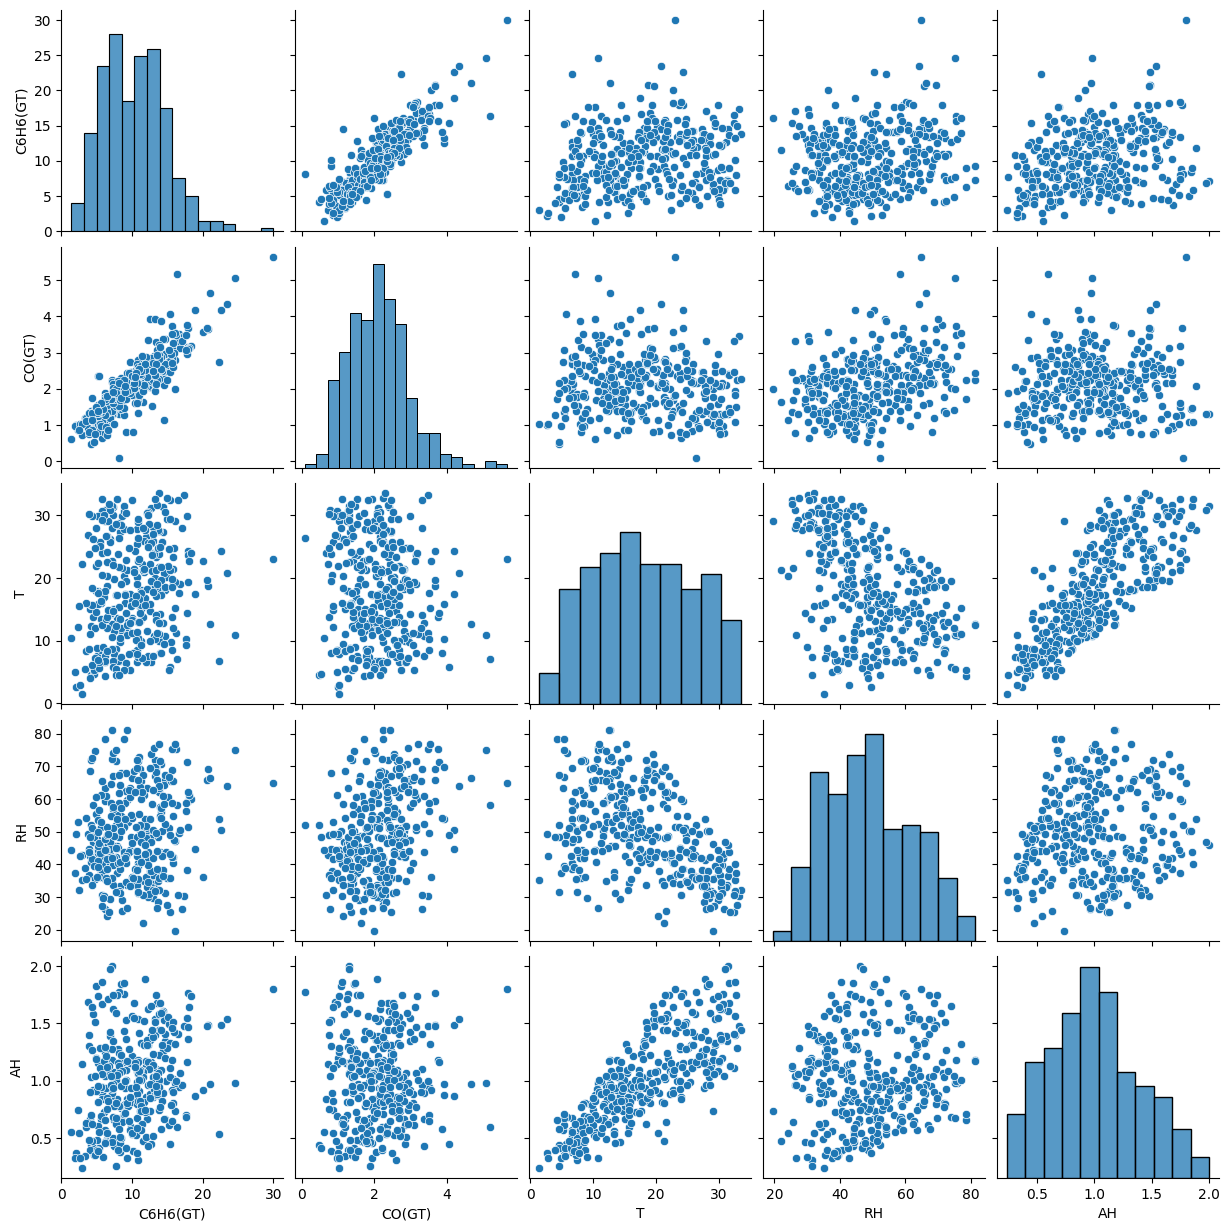

In [182]:
sns.pairplot(daily_avg_df)

###SLR Model - C6H6(GT) vs. CO(GT)

We will compare a model of using only CO(GT) to predict C6H6(GT) against the a model that uses all of our varibles of interest to predict C6H6(GT). Below we will determine the Mean Square Error of the simple linear regression of CO(GT) predicting C6H6(GT).

In [131]:
reg = linear_model.LinearRegression()

#Put the individual MSE's in a list so that you can search for a specific day if desired
MSE_list = []
start = 250
end = daily_avg_df.shape[0]


for current_day in range(start,end):
    x = daily_avg_df.loc[:current_day, 'CO(GT)'].values.reshape(-1,1)
    y = daily_avg_df.loc[:current_day, 'C6H6(GT)']

    #run fit and prediction
    reg.fit(x,y)
    pred = reg.predict(daily_avg_df.loc[current_day + 1, ['CO(GT)']].values.reshape(-1,1))

    #Print daily predicition and actual value
    print("Prediction for day " + str(current_day + 1) + " is " + str(pred[0]))
    print("Actual value for day " + str(current_day + 1) + " is " + str(daily_avg_df.loc[current_day + 1, 'C6H6(GT)']))

    #compute and print MSE
    MSE = metrics.mean_squared_error(daily_avg_df.loc[current_day + 1, ['C6H6(GT)']], pred)
    print("MSE for day " + str(current_day + 1) + " is " + str(MSE) + "\n")

    #Append daily MSE value to a list of MSE values.
    MSE_list.append(MSE)

#Sum up all MSE values to calculate the actual MSE of the prediction
sum_MSE = sum(MSE_list)
print("The sum of the daily MSE is " + str(sum_MSE))

Prediction for day 251 is 11.336003039566487
Actual value for day 251 is 8.069565217391304
MSE for day 251 is 10.669616046136552

Prediction for day 252 is 20.13678742030548
Actual value for day 252 is 15.387500000000001
MSE for day 252 is 22.55573100067188

Prediction for day 253 is 25.281716584540625
Actual value for day 253 is 16.342105263157894
MSE for day 253 is 79.91665057739431

Prediction for day 254 is 19.0597946285596
Actual value for day 254 is 13.217391304347826
MSE for day 254 is 34.133676602760794

Prediction for day 255 is 7.637005131257558
Actual value for day 255 is 4.779166666666667
MSE for day 255 is 8.167240689695223

Prediction for day 256 is 8.242549020674424
Actual value for day 256 is 5.7875000000000005
MSE for day 256 is 6.0272656939144476

Prediction for day 257 is 6.558321675991025
Actual value for day 257 is 4.1
MSE for day 257 is 6.043345462647325

Prediction for day 258 is 10.805660743428952
Actual value for day 258 is 7.31304347826087
MSE for day 258 is 1

###MLR Model

Next, we will use a Multiple Linear Regression model to predict C6H6(GT) from our other variables of interest. We use a similar approach here to determine the Mean Square Error. Comparing the MSE of both models will allow us to pick the better model.

In [138]:
MLR_reg = linear_model.LinearRegression()

#Put the individual MSE's in a list so that you can search for a specific day if desired
MLR_MSE_list = []
start = 250
end = daily_avg_df.shape[0]

for current_day in range(start,end):
    x = daily_avg_df.loc[:current_day, ['CO(GT)', 'T', 'RH', 'AH']]
    y = daily_avg_df.loc[:current_day, 'C6H6(GT)']

    #run fit and prediction
    MLR_reg.fit(x,y)
    MLR_pred = MLR_reg.predict(daily_avg_df.loc[[current_day + 1], ['CO(GT)', 'T', 'RH', 'AH']])

    #Print daily predicition and actual value
    print("Prediction for day " + str(current_day + 1) + " is " + str(MLR_pred[0]))
    print("Actual value for day " + str(current_day + 1) + " is " + str(daily_avg_df.loc[current_day + 1, 'C6H6(GT)']))

    #compute and print MSE
    MLR_MSE = metrics.mean_squared_error(daily_avg_df.loc[current_day + 1, ['C6H6(GT)']], MLR_pred)
    print("MSE for day " + str(current_day + 1) + " is " + str(MLR_MSE) + "\n")

    #Append daily MSE value to a list of MSE values.
    MLR_MSE_list.append(MLR_MSE)

#Sum up all MSE values to calculate the actual MSE of the prediction
MLR_sum_MSE = sum(MLR_MSE_list)
print("The sum of the daily MSE is " + str(MLR_sum_MSE))

Prediction for day 251 is 9.347122733106927
Actual value for day 251 is 8.069565217391304
MSE for day 251 is 1.632153205961474

Prediction for day 252 is 18.53383570654472
Actual value for day 252 is 15.387500000000001
MSE for day 252 is 9.899428378278264

Prediction for day 253 is 24.160531360611973
Actual value for day 253 is 16.342105263157894
MSE for day 253 is 61.12778664135102

Prediction for day 254 is 17.90409169970172
Actual value for day 254 is 13.217391304347826
MSE for day 254 is 21.965160595810342

Prediction for day 255 is 5.656629845251098
Actual value for day 255 is 4.779166666666667
MSE for day 255 is 0.7699416297714936

Prediction for day 256 is 6.434690127548773
Actual value for day 256 is 5.7875000000000005
MSE for day 256 is 0.41885506119659655

Prediction for day 257 is 4.295250376530525
Actual value for day 257 is 4.1
MSE for day 257 is 0.03812270953531201

Prediction for day 258 is 8.311449865738906
Actual value for day 258 is 7.31304347826087
MSE for day 258 is

###MSE function

We want turn this procedure into a function to potentially do this quickly with any varible we may be interested in.

In [172]:
def current_MSE_time(X, y, day):
    '''
    This function will take a data frame of predictors for the X arg, and a 1D response
    as the y arg. The day arg is the last day that should be used for the training set
    of the data. This will only give  the MSE and RMSE for next day.
    '''
    #subset the data for the training set
    _x = X.loc[:day]
    _y = y.loc[:day]
    reg = linear_model.LinearRegression()
    reg.fit(_x,_y)

    #predict using the test set (the next day)
    pred = reg.predict(X.loc[[day + 1]])

    #determine the Mean Square Error for the prediction of the next day
    MSE = metrics.mean_squared_error([y.loc[day + 1]], pred)
    return MSE


def sum_MSE_time(X, y, day):
    '''
    This function will take a data frame of predictors for the X arg, and a 1D response
    as the y arg. The day arg is the last day that should be used for the training set
    of the data. This will sum the MSE and RMSE for the entire test set.
    '''
    #Start with a MSE of 0
    sum_MSE = 0

    #Determine the last day of the dataset
    end = X.shape[0]

    #Run for loop for each day from start to the day before the last day
    for current_day in range(day,end):
        sum_MSE += current_MSE_time(X = X, y = y, day = current_day)

    #Return the sum of the daily MSE.
    print("The sum of the daily MSE is " + str(sum_MSE))
    return sum_MSE

In [173]:
sum_MSE_time(X = daily_avg_df[['CO(GT)']], y = daily_avg_df['C6H6(GT)'], day = 250)

The sum of the daily MSE is 718.0810286685651


718.0810286685651

In [174]:
sum_MSE_time(X = daily_avg_df[['CO(GT)', 'T', 'RH', 'AH']], y = daily_avg_df['C6H6(GT)'], day = 250)

The sum of the daily MSE is 494.34222176464584


494.34222176464584

###Conclusion

Based on the MSE values of ___ and ___ , we would select the multiple-linear-regression model due to the much lower MSE.

In [178]:
true_reg = linear_model.LinearRegression()
true_reg.fit(daily_avg_df[['CO(GT)', 'T', 'RH', 'AH']], daily_avg_df['C6H6(GT)'])

print(true_reg.coef_)
print(true_reg.intercept_)

[ 4.77080433  0.11973259 -0.01620259  0.68866811]
-1.8377694729981755


Using all of the data now to fit our model, we get the following:

```
C6H6(GT)_hat = -1.8377 + 4.7708*CO(GT) + 0.1197*T - 0.0162*RH + 0.6887*AH
```

Based on the slopes, CO(GT) has the most impact on predicting C6H6(GT), but the additional variables give us a bitter prediction on average.

Additional Study:


*   Look at MSE of other variables to see how they compare to the MSE of using CO(GT) to predict C6H6(GT).
*   Try using interaction variables to see if they change the model.
*   While, not given in our data, interest is shown in how the current precipiation amount changes the quantity of C6H6(GT). An indicator varible based on if it is raining or not may reveal other trends.

